In [1]:
import glob
import pandas as pd
import scipy.constants as scc
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import scipy
import scipy.stats as stats
from astropy.coordinates import SkyCoord
from scipy.integrate import quad
from matplotlib.offsetbox import AnchoredText
import os
import scipy.special as sc
import gc
import warnings
import eazy
import time
import grizli
import numpy as np
from astropy.table import Table

In [2]:
def Lv(freq, A, beta, Tdust):
    return A * freq**(3+beta) / (np.exp(h * freq / (k_b * Tdust ) ) - 1 )

def Lv_rescaled(freq, N, A, beta, Tdust):  # Lv
    return N * A * freq**(3+beta) / (np.exp(h * freq / (k_b * Tdust ) ) - 1 )

def T_dust(z):
    return 32.9 + 4.6*(z-2), 2.4+0.35*(z-2)  # mean value and dispersion

In [3]:
h = 6.62e-27 # erg/s
k_b = 1.38e-16 # erg/K
c = 3e10 # speed of light: cm/s
sigma = 5.67e-5 # stefan boltzmann constant, erg/cm^2/s/K^4

In [4]:
path='/home/yjm/miniconda/Outputs'
os.chdir(path)
os.chdir('./a370')

In [5]:
lamb_rest = (np.arange(8, 1200) * 1e-6  ) # micron meters to meters
freq_rest = scc.c / lamb_rest # Hz
freq_rest_8_1000 = scc.c / (np.arange(8, 1000) * 1e-6  )
freq_sorted = np.sort(freq_rest)
freq_8_1000_sorted = np.sort(freq_rest_8_1000)
index_1000 = np.where(lamb_rest==np.min(abs(freq_sorted-1)))
kappa0 = 1.3   # cm^2/g --> m^2/kg
v0 = 6.66e11  #Hz
M_16=[]
M_84=[]
M_50=[]
beta_median=[]
T_median=[]
L_16 = []
L_84 = []
L_UV = []
L_50 = []
detected_fits = glob.glob('*alma_detected.fits')[0]
table = Table.read(detected_fits)
magnification = np.array(table['magnification'])
Sv_obs = np.array(table['flux_1.2mm'])/magnification*1e-26   # from micron Jy to erg/sec/cm^2
redshift = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
lamb_alma = 1200/(1 + redshift)*1e-6   # --> meter
freq_alma = scc.c / lamb_alma
num_iteration=1000
beta = np.random.normal(1.8, 0.2, size=(num_iteration,))
a=2e-26
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

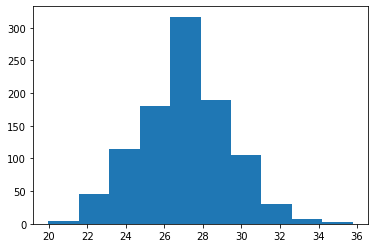

In [6]:
for j in range(redshift.size):
    d_L = cosmo.luminosity_distance(redshift[j])
    d_L = d_L.to(u.cm)  # from parsec to cm
    low, high = T_dust(redshift[j])
    T = np.random.normal(low, high, size=(num_iteration,))
    Lv_rest = 4*scc.pi*d_L**2*Sv_obs[0]/(1+redshift[j])  # unit: erg/s/Hz
    lamb_obs = lamb_rest * (1 + redshift[j])
    M_dust=[]
    t_peak=[]
    l_IR = []
    for i in range(num_iteration):      # loop over random T and beta
        N = Lv_rest.value / Lv(freq_alma[j], 2e-26, beta[i], T[i])
        Lv_rescale = N  * Lv(freq_rest, 2e-26, beta[i], T[i]) 
        Sv_rescale = Lv_rescale * (1 + redshift[j]) / (4 * np.pi * d_L**2)
        nu = 1.5e11 * (1+redshift[j])
        kappa = kappa0 * (nu / v0)**beta[i]    # m^2/kg
        # mistake here: Sv_rest and func() have different units
        L = Lv_rest.value / (Lv(freq_alma[j], a, beta[i], T[i]) )  * Lv(nu, a, beta[i], T[i])
        blackbody = 2 * h / c**2 * nu**3 / (np.exp(h*nu / (k_b*T[i])) - 1)
        mass = L / (4 * np.pi * kappa * blackbody )  # kg
        M_dust = np.append(M_dust, mass)
        #L_integrated = np.sum(Lv_rescale[0:-1]) * dx[-1]
        #sol=quad(Lv_rescaled, freq_rest_8_1000[-1], freq_rest_8_1000[0], args=(N, a, beta[i], T[i]))
        #L_integrated = sol[0]
        lamb_peak = scc.c / freq_rest[np.argmax(Lv_rescale)] * 1e6   # meter --> um
        T_peak = 2898 / lamb_peak
        t_peak = np.append(t_peak, T_peak)
        L_integrated = 4 *np.pi * d_L.value**2 * sigma * T_peak**4
        l_IR = np.append(l_IR, L_integrated/3.82e33 ) # in unit of L_sun
    if j==0:
        plt.hist(t_peak)
    m_16 = np.percentile(M_dust, 16, method='nearest')
    M_16 = np.append(M_16, m_16)
    m_84 = np.percentile(M_dust, 84, method='nearest')
    M_84 = np.append(M_84, m_84)
    l_16 = np.percentile(l_IR, 16, method='nearest')
    L_16 = np.append(L_16, l_16)
    l_50 = np.percentile(l_IR, 50, method='nearest')
    L_50 = np.append(L_50, l_50)
    l_84 = np.percentile(l_IR, 84, method='nearest')
    L_84 = np.append(L_84, l_84)
    m_50 = np.percentile(M_dust, 50, method='nearest')
    M_50 = np.append(M_50, m_50)

In [7]:
print(Lv_rescale)

[5.27595539e+27 4.52227690e+28 2.39942374e+29 ... 1.52956189e+29
 1.52522014e+29 1.52089422e+29]


In [8]:
print()

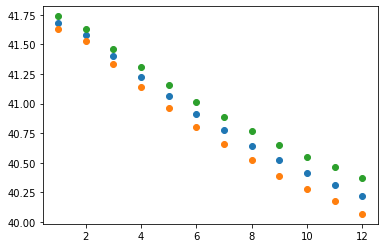

In [9]:
#Mdust_errors = np.vstack([(M_50 - M_16), (M_84 - M_50)])

plt.scatter(redshift, np.log10(M_50))
plt.scatter(redshift, np.log10(M_16))
plt.scatter(redshift, np.log10(M_84))
#plt.errorbar(redshift, np.log10(M_50), yerr=np.log10(Mdust_errors))

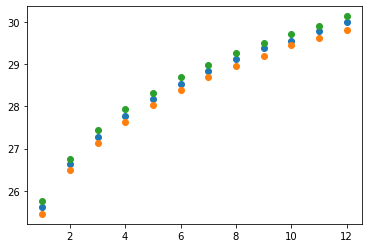

In [10]:
plt.scatter(redshift, np.log10(L_50))
plt.scatter(redshift, np.log10(L_16))
plt.scatter(redshift, np.log10(L_84))